# Pytorch Implementation of EEGLearn - P. Bashivan

This notebook describes a short summary of Pytorch implementation of the models described in "Learning Representations from EEG with Deep Recurrent-Convolutional Neural Networks." Bashivan et al. at International conference on learning representations (2016).

The rest of the code is in the different python scripts of this repo.

All the codes have been inspired from the [original github](https://github.com/pbashivan/EEGLearn).

## Librairies Import

In [1]:
import numpy as np 
import scipy.io as sio
from scipy import signal
import torch
import os 
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader,random_split
from matplotlib import pyplot as plt

from Utils import *
from Models import *

torch.manual_seed(1234)
np.random.seed(1234)

import warnings
warnings.simplefilter("ignore")

## Loading the original Images 
The images have directly been taken from original implementation, given that they remain the same nevermind the implementation (Pytorch, Tensorflow, Theano).

## Loading patient dataset 
From the total data, we select the images corresponding patient. 

In [96]:
chosen_patient = 1
# load file from folder kamyar_data
# files = sio.loadmat("kamyar_data/TrainData1.mat")['TrainData1']
files = sio.loadmat("kamyar_data/TestData1.mat")['TestData1']
Mean_Images = files[:,:]
Label = files[:,9]


In [97]:
 # **************************** Data Segmentation *********************
def DataSegmentation(data, t1, t2):
    Data_Frame = pd.DataFrame()
    df = pd.DataFrame(data)
    dt = df.loc[0][1] - df.loc[0][0]
    fs = 1/dt
    sample_num = np.floor((t1+t2)*fs)
    epoch_loc = np.where(np.diff(np.sign(df.loc[9])) == 1)[0] + 1
    for j in range(1,9):
        signals = []
        for i in range(epoch_loc.shape[0]):
            temp = df.loc[j][epoch_loc[i]-np.int64(t1*fs) : epoch_loc[i]+np.int64(t2*fs)+1].values
            # temp = temp/np.max(abs(temp))
            signals.append(temp)
        Data_Frame['Ch' + str(j)] = signals
    Data_Frame['ChannelMean'] = [[0] for i in range(Data_Frame.shape[0])]
    for i in range(Data_Frame.shape[0]):
        Data_Frame['ChannelMean'][i] = np.mean(Data_Frame.loc[i][:-1])

    try:
        target_loc = np.where(df.loc[10] == 1)[0]
        labels = np.zeros(epoch_loc.shape)
        for i in range(target_loc.shape[0]):
            temp = np.where(epoch_loc == target_loc[i])[0]
            if temp.shape[0] == 0:
                continue
            labels[temp[0]] = 1
        Data_Frame['labels'] = labels
        return (Data_Frame, fs, pd.DataFrame(data).loc[9][epoch_loc].values)
    except:
        return (Data_Frame, fs, pd.DataFrame(data).loc[9][epoch_loc].values)

In [98]:
signal = np.zeros((2700,8,128))
df, _, _ = DataSegmentation(files, 0.1, 0.4)
labels = df['labels'].values
for ch in range(1,9):
    for i in range(df.shape[0]):
        signal[i,ch-1,:] = df.iloc[i][f"Ch{ch}"]

KeyError: 'labels'

In [ ]:
def calculate_sub_band_energy(eeg_data, sampling_rate):
    # Define frequency bands
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    # Apply FFT
    fft_result = np.fft.fft(eeg_data)
    freqs = np.fft.fftfreq(len(eeg_data), d=1/sampling_rate)

    # Function to calculate band power
    def band_power(band):
        band_freqs = (freqs >= band[0]) & (freqs <= band[1])
        return np.sum(np.abs(fft_result[band_freqs]) ** 2)

    # Calculate power for each band
    theta_power = band_power(theta_band)
    alpha_power = band_power(alpha_band)
    beta_power = band_power(beta_band)
    return theta_power, alpha_power, beta_power

In [ ]:
# send signal to calculate_sub_band_energy
theta_power = np.zeros((2700,8))
alpha_power = np.zeros((2700,8))
beta_power = np.zeros((2700,8))
for i in range(2700):
    for ch in range(8):
        theta_power[i,ch], alpha_power[i,ch], beta_power[i,ch] = calculate_sub_band_energy(signal[i,ch,:], 240)
# concatenate the features
features = np.concatenate((theta_power, alpha_power, beta_power), axis=1)

In [99]:
features.shape

(2700, 24)

In [100]:
# # each row of mean_images represents a signal in time domain, take the wavelet transform of each row
# cwts,_,_ = DataSegmentation(Mean_Images, 100/1000, 400/1000)

In [101]:
# signals = cwts.iloc[:,:-2].values
# signals = signals.flatten()
# signals = np.array([np.array(signals[i]) for i in range(signals.shape[0])])
# print (signals.shape)
# labels = cwts.iloc[:,-1].values

In [102]:
# # convert each row of signals to wavelet transform matrix
# wavelets = np.zeros((signals.shape[0], 128, 128))
# for i in range(signals.shape[0]):
#     wavelets[i,:,:] = signal.cwt(signals[i,:], signal.ricker, np.arange(1, 129))
    
# wavelets = wavelets.reshape((wavelets.shape[0], 1, wavelets.shape[1], wavelets.shape[2]))
# wavelets = wavelets.reshape((int(wavelets.shape[0] / 8), 8, wavelets.shape[2], wavelets.shape[3]))
# print (wavelets.shape)
# print (labels.shape)

In [103]:
# signals = signals.reshape((signals.shape[0], 1, signals.shape[1], wavelets.shape[2]))
# wavelets = wavelets.reshape((int(wavelets.shape[0] / 8), 8, wavelets.shape[2], wavelets.shape[3]))
# print (wavelets.shape)
# print (labels.shape)

In [104]:
# Electrode coordinates in polar form (angle in degrees, radial distance)
electrode_polar_coordinates = np.array([
    [18, 0.406],   # Fp2
    [-18, 0.406],  # Fp1
    [-90, 0.406],  # T7
    [90, 0.406],   # T8
    [90, 0.203],   # C4
    [-162, 0.406], # O1
    [-90, 0.203],  # C3
    [162, 0.406]   # O2
])

# Convert angles from degrees to radians
angles_rad = np.radians(electrode_polar_coordinates[:, 0])

# Calculate Cartesian coordinates
y = electrode_polar_coordinates[:, 1] * np.cos(angles_rad)
x = electrode_polar_coordinates[:, 1] * np.sin(angles_rad)

# Combine x and y into a single array
electrode_cartesian_coordinates = np.column_stack((x, y))

# Displaying the Cartesian coordinates
print(electrode_cartesian_coordinates)


[[ 1.25460900e-01  3.86128946e-01]
 [-1.25460900e-01  3.86128946e-01]
 [-4.06000000e-01  2.48603300e-17]
 [ 4.06000000e-01  2.48603300e-17]
 [ 2.03000000e-01  1.24301650e-17]
 [-1.25460900e-01 -3.86128946e-01]
 [-2.03000000e-01  1.24301650e-17]
 [ 1.25460900e-01 -3.86128946e-01]]


In [105]:
# copying utils from big repo
def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)


def augment_EEG(data, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.

    :param data: EEG feature data as a matrix (n_samples x n_features)
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros(data.shape)
    if pca:
        pca = PCA(n_components=n_components)
        pca.fit(data)
        components = pca.components_
        variances = pca.explained_variance_ratio_
        coeffs = np.random.normal(scale=stdMult, size=pca.n_components) * variances
        for s, sample in enumerate(data):
            augData[s, :] = sample + (components * coeffs.reshape((n_components, -1))).sum(axis=0)
    else:
        # Add Gaussian noise with std determined by weighted std of each feature
        for f, feat in enumerate(data.transpose()):
            augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)
    return augData


def augment_EEG_image(image, std_mult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.

    :param image: EEG feature data as a a colored image [n_samples, n_colors, W, H]
    :param std_mult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros((data.shape[0], data.shape[1], data.shape[2] * data.shape[3]))
    for c in range(image.shape[1]):
        reshData = np.reshape(data['featMat'][:, c, :, :], (data['featMat'].shape[0], -1))
        if pca:
            augData[:, c, :] = augment_EEG(reshData, std_mult, pca=True, n_components=n_components)
        else:
            augData[:, c, :] = augment_EEG(reshData, std_mult, pca=False)
    return np.reshape(augData, data['featMat'].shape)


def load_data(data_file):
    """
    Loads the data from MAT file. MAT file should contain two
    variables. 'featMat' which contains the feature matrix in the
    shape of [samples, features] and 'labels' which contains the output
    labels as a vector. Label numbers are assumed to start from 1.

    Parameters
    ----------
    data_file: str

    Returns
    -------
    data: array_like
    """
    print("Loading data from %s" % (data_file))

    dataMat = scipy.io.loadmat(data_file, mat_dtype=True)

    print("Data loading complete. Shape is %r" % (dataMat['featMat'].shape,))
    return dataMat['features'][:, :-1], dataMat['features'][:, -1] - 1   # Sequential indices


def reformatInput(data, labels, indices):
    """
    Receives the the indices for train and test datasets.
    Outputs the train, validation, and test data and label datasets.
    """

    trainIndices = indices[0][len(indices[1]):]
    validIndices = indices[0][:len(indices[1])]
    testIndices = indices[1]
    # Shuffling training data
    # shuffledIndices = np.random.permutation(len(trainIndices))
    # trainIndices = trainIndices[shuffledIndices]
    if data.ndim == 4:
        return [(data[trainIndices], np.squeeze(labels[trainIndices]).astype(np.int32)),
                (data[validIndices], np.squeeze(labels[validIndices]).astype(np.int32)),
                (data[testIndices], np.squeeze(labels[testIndices]).astype(np.int32))]
    elif data.ndim == 5:
        return [(data[:, trainIndices], np.squeeze(labels[trainIndices]).astype(np.int32)),
                (data[:, validIndices], np.squeeze(labels[validIndices]).astype(np.int32)),
                (data[:, testIndices], np.squeeze(labels[testIndices]).astype(np.int32))]

In [106]:
def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes

    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = np.uint(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    n_samples = features.shape[0]

    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([n_samples, n_gridpoints, n_gridpoints]))

    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]]), axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((n_samples, 4)), axis=1)

    # Interpolating
    for i in range(n_samples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                               method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i + 1, n_samples), end='\r')

    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


In [107]:
n_gridpoints = 32
# Generate images
images = gen_images(electrode_cartesian_coordinates, features, n_gridpoints, augment=True, pca=False, std_mult=0.1, n_components=2, edgeless=False)
print (images.shape)

Interpolating 2700/2700terpolating 61/2700Interpolating 138/2700Interpolating 208/2700Interpolating 283/2700Interpolating 349/2700Interpolating 415/2700Interpolating 483/2700Interpolating 552/2700Interpolating 612/2700Interpolating 676/2700Interpolating 753/2700Interpolating 815/2700Interpolating 891/2700Interpolating 969/2700Interpolating 1033/2700Interpolating 1102/2700Interpolating 1168/2700Interpolating 1230/2700Interpolating 1298/2700Interpolating 1360/2700Interpolating 1435/2700Interpolating 1511/2700Interpolating 1590/2700Interpolating 1647/2700Interpolating 1720/2700Interpolating 1793/2700Interpolating 1860/2700Interpolating 1932/2700Interpolating 2005/2700Interpolating 2080/2700Interpolating 2157/2700Interpolating 2235/2700Interpolating 2312/2700Interpolating 2393/2700Interpolating 2472/2700Interpolating 2547/2700Interpolating 2623/2700(2700, 3, 32, 32)


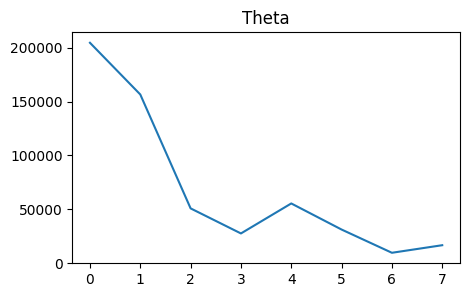

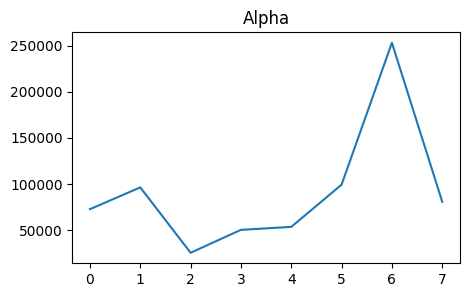

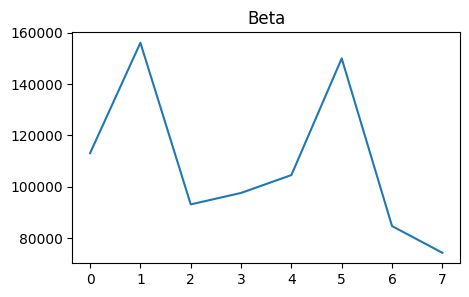

In [108]:
# plot features
plt.figure(figsize=(5, 3))
plt.plot(features[0, :8])
plt.title('Theta')
plt.figure(figsize=(5, 3))
plt.plot(features[0, 8:16])
plt.title('Alpha')
plt.figure(figsize=(5, 3))
plt.plot(features[0, 16:24])
plt.title('Beta')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


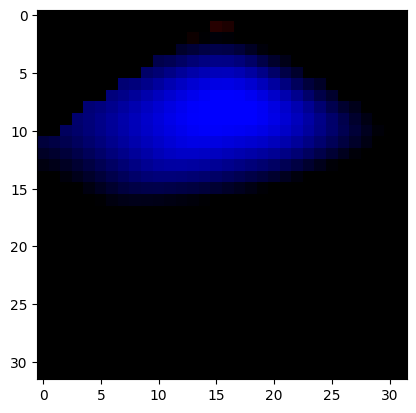

In [109]:
# plot one image
plt.imshow(np.transpose(images[2552,:,:,:], (1,2,0)))

## Introduction: BasicCNN
First Implementation of a CNN on the Mean Images from each patient

In [110]:
train_part = 0.8
test_part = 0.2

batch_size = 32

In [111]:
# cast labels to long int
labels = labels.astype(np.int64)
print (labels.shape)

(2700,)


In [112]:
wavelets = images
print (wavelets.shape)
# # split data into two parts based on labels being 0 or 1
# wavelets_0 = wavelets[labels == 0]
# print (wavelets_0.shape)
# wavelets_1 = wavelets[labels == 1]
# # shuffle both and corresponding elements of labels
# inds = np.arange(wavelets_0.shape[0])

# wavelets_0 = wavelets_0[inds]
# labels_0 = labels[labels == 0][inds]

# wavelets_1 = wavelets_1[:,:,:,:]
# labels_1 = labels[labels == 1]

# # take train_part of each
# wavelets_0_train = wavelets_0[:int(wavelets_0.shape[0] * train_part)]
# labels_0_train = labels_0[:int(labels_0.shape[0] * train_part)]
# wavelets_1_train = wavelets_1[:int(wavelets_1.shape[0] * train_part)]
# labels_1_train = labels_1[:int(labels_1.shape[0] * train_part)]
# # take test_part of each
# wavelets_0_test = wavelets_0[int(wavelets_0.shape[0] * train_part):]
# labels_0_test = labels_0[int(labels_0.shape[0] * train_part):]
# wavelets_1_test = wavelets_1[int(wavelets_1.shape[0] * train_part):]
# labels_1_test = labels_1[int(labels_1.shape[0] * train_part):]
# # concatenate wavelets_0_train and wavelets_1_train
# wavelets_train = np.concatenate((wavelets_0_train, wavelets_1_train), axis=0)
# labels_train = np.concatenate((labels_0_train, labels_1_train), axis=0)
# # concatenate wavelets_0_test and wavelets_1_test
# wavelets_test = np.concatenate((wavelets_0_test, wavelets_1_test), axis=0)
# labels_test = np.concatenate((labels_0_test, labels_1_test), axis=0)

(2700, 3, 32, 32)


In [113]:
labels = 1-labels
EEG = EEGImagesDataset(label=labels, image=wavelets)

lengths = [int(len(EEG)*train_part), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [114]:
# res = TrainTest_Model(BasicCNN, Trainloader, Testloader, n_epoch=15, learning_rate=0.001, print_epoch=-1, opti='Adam')

In [115]:
net = BasicCNN()
net.load_state_dict(torch.load('kamyar_model_weights.pth', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()

res, embeddings = Test_Model(net, Testloader, criterion, True)
print (res)

(39.71507812948788, 0.20925925925925926, [tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1]), tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0]), tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1]), tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1]), tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0]), tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1]), tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,

In [70]:
embeddings = np.array([n.detach().numpy() for n in embeddings])
print (embeddings)
print (embeddings.shape)

[array([[ 3.7522006 ,  3.546122  , -3.248651  , ...,  3.4633439 ,
          3.4993126 , -3.624056  ],
        [ 3.0211027 ,  2.8233914 , -2.6111176 , ...,  2.7357895 ,
          2.8053408 , -2.91431   ],
        [ 2.1892145 ,  2.6486785 , -2.368852  , ...,  2.1548307 ,
          1.7934935 , -1.2747927 ],
        ...,
        [ 2.8807    ,  2.755745  , -2.5296214 , ...,  2.6666436 ,
          2.9739754 , -2.7173297 ],
        [ 1.0795515 ,  2.3848166 , -2.5015984 , ...,  1.9586843 ,
         -0.45966703,  1.3758335 ],
        [ 4.460752  ,  4.030407  , -3.7668378 , ...,  4.044812  ,
          4.0281973 , -4.2467065 ]], dtype=float32)
 array([[ 3.7076406,  3.5315175, -3.1147258, ...,  3.4224887,  3.498782 ,
         -3.6050467],
        [ 2.8827832,  2.6474423, -2.3594325, ...,  2.5671895,  2.6779501,
         -2.7695165],
        [ 3.4432776,  3.214491 , -2.9587073, ...,  3.149809 ,  3.1965215,
         -3.3328483],
        ...,
        [ 1.5739388,  1.3832619, -1.1373929, ...,  1.27573

In [37]:
embeddings[-1].shape

(28, 512)

In [62]:
np.concatenate(res[2])

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [71]:
# balanced accuracy of true: x and pred: y
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
def balanced_accuracy(x, y):
    return (balanced_accuracy_score(x, y))
print(balanced_accuracy(np.concatenate(res[2]), np.concatenate(res[3])))
print(confusion_matrix(np.concatenate(res[2]), np.concatenate(res[3])))

0.4816865513430614
[[ 95   6]
 [429  10]]


In [116]:
net = BasicCNN()
net.load_state_dict(torch.load('kamyar_model_weights.pth', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
net.eval()

BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (max): LogSoftmax(dim=None)
)

In [117]:
Embeddings = np.zeros((wavelets.shape[0], 512))
for i in range(wavelets.shape[0]):
    if i % 100 == 0:
        print (i)
    Embeddings[i, :] = net(torch.tensor(wavelets[i:i+1,:,:,:]).to(torch.float32))[1].detach().numpy()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [95]:
# Save the embeddings in .mat file
sio.savemat('kamyar_embeddings_test.mat', {'Images':images,'embeddings': Embeddings, 'labels': labels})

## Maxpool CNN
Build the Max-pooling model performing a maxpool over the 7 parallel convnets.

In [24]:
train_part = 0.8
test_part = 0.2

batch_size = 32

In [25]:
EEG = EEGImagesDataset(label=labels, image=wavelets)

lengths = [int(len(EEG)*train_part), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [26]:
res = TrainTest_Model(MaxCNN, Trainloader, Testloader, n_epoch=1, learning_rate=0.001, print_epoch=5, opti='Adam')

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 32, 32, 32] to have 3 channels, but got 32 channels instead

In [ ]:
net = MaxCNN()
net.load_state_dict(torch.load('MaxCNN.pt'))
criterion = nn.CrossEntropyLoss()

res, embeddings = Test_Model(net, Testloader, criterion, True)

## Temp CNN
FBuild the Conv1D model performing a convolution1D over the 7 parallel convnets.

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(TempCNN, Trainloader, Testloader, n_epoch=45, learning_rate=0.001, print_epoch=5, opti='Adam')

## LSTM CNN
Build the LSTM model applying a RNN over the 7 parallel convnets outputs

In [ ]:
EEG = EEGImagesDataset(label=Label[Patient_id==choosen_patient], image=Images[Patient_id==choosen_patient])

lengths = [int(len(EEG)*train_part+1), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(LSTM, Trainloader, Testloader, n_epoch=45, learning_rate=0.0001, print_epoch=5, opti='Adam')

## Mix CNN
Build the LSTM model applying a RNN and a CNN over the 7 parallel convnets outputs

In [ ]:
EEG = EEGImagesDataset(label=Label[Patient_id==choosen_patient], image=Images[Patient_id==choosen_patient])

lengths = [int(len(EEG)*train_part+1), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(Mix, Trainloader, Testloader, n_epoch=60, learning_rate=0.00001, print_epoch=5, opti='Adam')